In [1]:
import pandas as pd
import fastai.text as ftxt
import sklearn.model_selection as skms
import numpy as np
import spacy as sp
import pickle
import os

In [2]:
#import torch

In [3]:
#torch.cuda.is_available()

In [4]:
#torch.__version__

In [5]:
path = os.getcwd()
path

'/media/rinnely/Archer/ENES/Stance/legal_abortion'

In [6]:
path = os.getcwd()
topic = 'la'
os.makedirs(path+'/NN/'+ topic, exist_ok=True)
path_nn_model= path+'/NN/'+topic
path_nn_model

'/media/rinnely/Archer/ENES/Stance/legal_abortion/NN/la'

In [8]:
tweets = pd.read_csv(path+'/alldatala.csv')

In [9]:
tweets.head()

,Unnamed: 0,Tweet,Stance
0,0,Just laid down the law on abortion in my bioet...,-1
1,1,@tooprettyclub Are you OK with #GOP males tell...,1
2,2,"If you don't want your kid, put it up for adop...",-1
3,3,"@RedAlert -there should be a ""stigma"" to butch...",-1
4,4,But isn't that the problem then. Not enough fa...,0


In [10]:
tweets = tweets[['Stance', 'Tweet']]

In [11]:
tweets.head()

,Stance,Tweet
0,-1,Just laid down the law on abortion in my bioet...
1,1,@tooprettyclub Are you OK with #GOP males tell...
2,-1,"If you don't want your kid, put it up for adop..."
3,-1,"@RedAlert -there should be a ""stigma"" to butch..."
4,0,But isn't that the problem then. Not enough fa...


In [12]:
tweets.Stance.unique()

array([-1,  1,  0])

In [61]:
tweets['Stance']=tweets.Stance.replace({'FAVOR':1, 'AGAINST':-1, 'NONE':0})

In [13]:
train, test = skms.train_test_split(tweets, test_size=.30)

In [14]:
train.shape, test.shape

((2815, 2), (1207, 2))

In [15]:
train.to_csv(path_nn_model+'/train_tweets70.csv', index=False)
test.to_csv(path_nn_model+'/test_tweets30.csv', index=False)

In [7]:
train = pd.read_csv(path_nn_model+'/train_tweets70.csv')
test = pd.read_csv(path_nn_model+'/test_tweets30.csv')

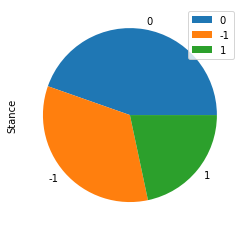

In [17]:
train['Stance'].value_counts().plot.pie(legend=True)

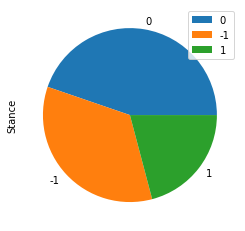

In [18]:
test['Stance'].value_counts().plot.pie(legend=True)

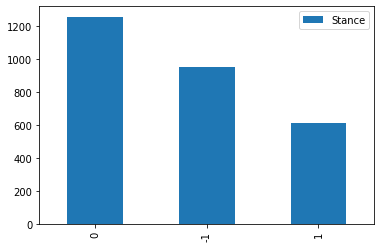

In [19]:
train['Stance'].value_counts().plot.bar(legend=True)

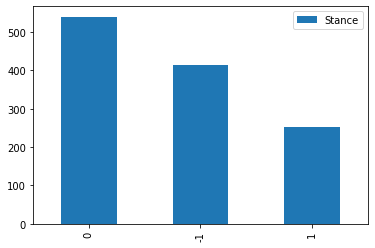

In [20]:
test['Stance'].value_counts().plot.bar(legend=True)

In [21]:
train

,Stance,Tweet
0,-1,mt @politicsiswar: for convenience...
1,0,only $0.99 on pastor sally gives practical and...
2,1,"you know, it takes two to tango... here's why ..."
3,1,"women's rights are threatened at national, sta..."
4,-1,faces that come to my mind when hearing argume...
...,...,...
2810,1,why do we live in a society that teaches 'don'...
2811,-1,RT @ProLifeYouth: #SCOTUS says they support eq...
2812,0,fascinating peek behind the curtain on the wis...
2813,1,here are 3 things you can do - right now - to ...


In [8]:
data_lm = ftxt.TextLMDataBunch.from_df(path_nn_model, train, test, bs=32)
data_clas = ftxt.TextClasDataBunch.from_df(path_nn_model, train, test, vocab=data_lm.train_ds.vocab, bs=32)

In [23]:
data_lm.show_batch()

idx,text
0,"to my mind when hearing arguments in defense of abortion . we must protect and defend our next generation . xxbos the xxunk of xxunk you killed your baby ! xxbos just because u were xxunk does n't mean that u have to be a xxunk . never let what hurt u make u become what u hate . xxbos do n’t xxunk mike pence for protecting his marriage ,"
1,"xxunk : "" i hope the house will find that a sensible way of dealing with this challenge . "" xxbos visit xxbos if they ca n't see how incredible you are , they are blind and xxunk . do n't let them lies xxunk you . forgive fast . love hard . # lovewins xxunk xxbos so # xxunk signed a "" joint xxunk "" ; is that ?"
2,"during ‘ xxunk recess ’ tomorrow . xxbos how to educate about abortion : a guide for peer xxunk , xxunk and teachers : xxunk xxbos "" choose life . "" xxbos xxmaj so xxunk ! xxmaj listening to @glennbeck xxup live & he s talking about # xxunk being total xxmaj evil . xxmaj even if you 're pro- ! xxbos xxunk ! xxunk xxunk it ! ! feminism"
3,"xxunk xxbos both sides of trans student 's case agree : # scotus should resolve title xxunk question . here 's xxunk 's letter : xxbos # prolife leaders ‘ xxunk it ’ to # plannedparenthood with 196,543 baby socks xxbos .@potus 's order on # immigration will go into partial effect tonight at 8 et . more on the order & & # scotus ruling : xxbos # abortion"
4,this xxunk here xxbos xxunk xxunk proud of the whole # periscope team & & super honoured to be part of this true global ! xxbos xxup wh : xxmaj motherhood 's a xxmaj wage xxmaj penalty . xxmaj so we pay em to have kids & we pay em to kill premature babies . xxup wtf 's point here libs ? xxbos we 're 7 today ! thank you


In [24]:
data_clas.show_batch()

text,target
xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxrep 5 7 xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk let everything that has breath praise the lord # chooselife > < >,-1
"xxbos xxunk xxunk xxunk xxunk # xxunk & & # xxunk knew the # aca , # xxunk , # scotus , # civilrights , # lgbtq & & women 's repro health was on the line & & they did n't care !",0
"xxbos doc : john , we think you have a xxunk of # marriage . do you know what the xxunk are ? john : ca n't say i do . doc : that 's one of them , yes .",0
xxbos # xxup potus xxunk his legacy w / 1 / 2 xxunk wins . xxmaj the # xxup gop agenda ? xxup still ! ! xxmaj repeal # xxmaj gun laws & # xxmaj obamacare xxmaj ban xxmaj access 2,-1
"xxbos xxmaj woman 's xxmaj heartbreaking xxmaj letter to xxmaj father of xxmaj baby xxmaj she xxmaj aborted : "" i 'm xxmaj so xxmaj very xxmaj sorry - xxunk . xxmaj please pray for the men hurt by abortion",-1


In [9]:
data_lm.save(path_nn_model+'/data_lm.pkl')
data_clas.save(path_nn_model+'/data_clas.pkl')

In [10]:
data_lm.train_ds.vocab.itos[:10], len(data_lm.train_ds.vocab.itos)

(['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  '#'],
 3032)

In [11]:
learn = ftxt.language_model_learner(data_lm, arch=ftxt.AWD_LSTM, drop_mult=.2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 5.25E-02


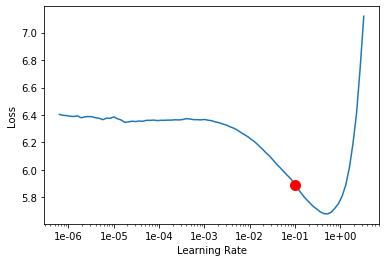

In [12]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [13]:
learn.fit_one_cycle(10,1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,5.900771,4.915093,0.182305,00:04
1,5.092073,4.206308,0.231494,00:04
2,4.485755,4.151727,0.241883,00:04
3,3.990344,4.198945,0.246550,00:04
4,3.541256,4.274823,0.247200,00:04
5,3.138107,4.356168,0.247200,00:04
6,2.780982,4.439420,0.244562,00:04
7,2.478004,4.488946,0.243831,00:04
8,2.256229,4.497141,0.245414,00:04
9,2.103552,4.500517,0.245536,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-07


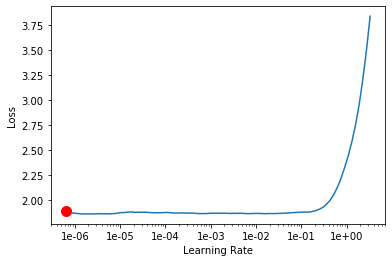

In [14]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [15]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.862927,4.502637,0.245455,00:04
1,1.854192,4.513050,0.245739,00:04
2,1.846575,4.537287,0.244562,00:04
3,1.837784,4.556293,0.244399,00:04
4,1.818830,4.571100,0.243912,00:04
5,1.794989,4.584770,0.243019,00:04
6,1.781455,4.593677,0.242857,00:04
7,1.761212,4.597474,0.242735,00:04
8,1.737357,4.601150,0.242817,00:04
9,1.726074,4.601181,0.242979,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.91E-07


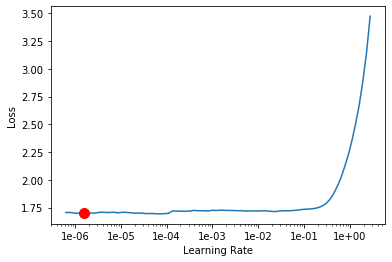

In [16]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [17]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.692089,4.605783,0.242370,00:04
1,1.692521,4.614554,0.242330,00:04
2,1.691322,4.644682,0.240260,00:04
3,1.691836,4.650193,0.240747,00:04
4,1.676050,4.669600,0.240544,00:04
5,1.655505,4.683705,0.240097,00:04
6,1.633556,4.693918,0.240179,00:04
7,1.618945,4.700221,0.239976,00:04
8,1.601953,4.701428,0.239286,00:04
9,1.586793,4.701912,0.239164,00:04


In [18]:
learn.save_encoder(path_nn_model+'/ml_encoder')

In [19]:
learn.save('la-model')

In [20]:
learn = ftxt.text_classifier_learner(data_clas, ftxt.AWD_LSTM, drop_mult=0.5)

In [21]:
learn.load_encoder(path_nn_model+'/ml_encoder')
learn.metrics=[ftxt.accuracy, ftxt.FBeta(average='micro')]

In [23]:
learn.save('learner-1stage')

In [24]:
learn.load('learner-1stage');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03
Min loss divided by 10: 1.00E-02


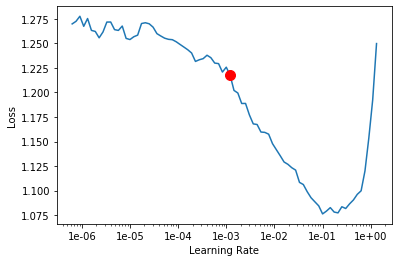

In [22]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [25]:
learn.fit_one_cycle(10,1.2e-03,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.076954,0.944965,0.549296,0.549296,00:04
1,0.944441,0.835229,0.628003,0.628003,00:04
2,0.864770,0.778959,0.637117,0.637117,00:04
3,0.816742,0.765638,0.674399,0.674399,00:03
4,0.791128,0.746989,0.678542,0.678542,00:04
5,0.773575,0.739352,0.681856,0.681856,00:03
6,0.741217,0.742492,0.666114,0.666114,00:04
7,0.723843,0.730914,0.670257,0.670257,00:04
8,0.724789,0.725550,0.675228,0.675228,00:03
9,0.725285,0.726450,0.684341,0.684341,00:04


In [26]:
learn.save('learner-2stage')

In [27]:
learn.load('learner-2stage');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.10E-07


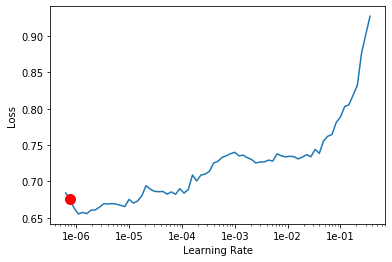

In [28]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [29]:
learn.fit_one_cycle(10,7.6e-07,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.697022,0.725109,0.685170,0.685170,00:04
1,0.705207,0.726206,0.679370,0.679370,00:03
2,0.720618,0.726175,0.681027,0.681027,00:04
3,0.703431,0.724414,0.678542,0.678542,00:03
4,0.695162,0.727888,0.679370,0.679370,00:04
5,0.715883,0.726362,0.676885,0.676885,00:04
6,0.698245,0.727386,0.673571,0.673571,00:03
7,0.688839,0.726281,0.677713,0.677713,00:03
8,0.702672,0.727601,0.675228,0.675228,00:04
9,0.723460,0.725795,0.680199,0.680199,00:04


In [30]:
learn.save('learner-stage')

In [31]:
learn.load('learner-stage');

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 3.02E-04


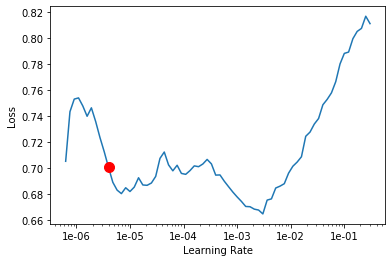

In [32]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [33]:
learn.fit_one_cycle(10,4e-06,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.707356,0.726433,0.682684,0.682684,00:04
1,0.705140,0.724922,0.683513,0.683513,00:03
2,0.673359,0.723547,0.683513,0.683513,00:03
3,0.712098,0.727426,0.682684,0.682684,00:04
4,0.709721,0.726140,0.676056,0.676056,00:04
5,0.692739,0.724060,0.684341,0.684341,00:03
6,0.702052,0.725289,0.680199,0.680199,00:04
7,0.693806,0.727045,0.682684,0.682684,00:04
8,0.711985,0.731117,0.675228,0.675228,00:04
9,0.701759,0.725655,0.685170,0.685170,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05
Min loss divided by 10: 1.74E-06


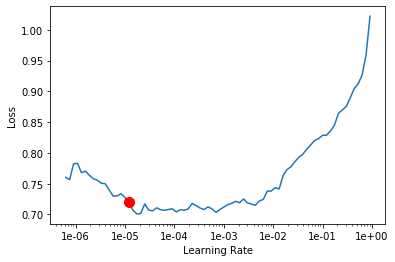

In [34]:
learn.freeze_to(-2)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [36]:
learn.fit_one_cycle(10,3e-05, moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.710326,0.724171,0.682684,0.682684,00:04
1,0.710894,0.723387,0.681856,0.681856,00:04
2,0.710738,0.718623,0.685998,0.685998,00:04
3,0.686948,0.716505,0.686827,0.686827,00:04
4,0.682507,0.718085,0.686827,0.686827,00:04
5,0.685789,0.712679,0.690141,0.690141,00:04
6,0.682260,0.717111,0.686827,0.686827,00:04
7,0.707718,0.715034,0.688484,0.688484,00:04
8,0.686348,0.713285,0.690141,0.690141,00:04
9,0.683778,0.711142,0.691798,0.691798,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.00E-04


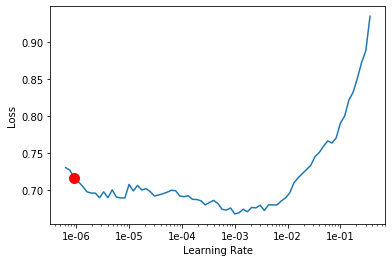

In [37]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [38]:
learn.fit_one_cycle(10,9e-07,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.677002,0.716724,0.683513,0.683513,00:04
1,0.672905,0.715796,0.685998,0.685998,00:04
2,0.686339,0.714284,0.686827,0.686827,00:04
3,0.686879,0.718839,0.678542,0.678542,00:04
4,0.679696,0.717926,0.680199,0.680199,00:04
5,0.672599,0.718317,0.679370,0.679370,00:04
6,0.699872,0.715563,0.688484,0.688484,00:04
7,0.672340,0.713170,0.693455,0.693455,00:04
8,0.683867,0.712830,0.691798,0.691798,00:04
9,0.678299,0.717110,0.690969,0.690969,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 3.31E-07


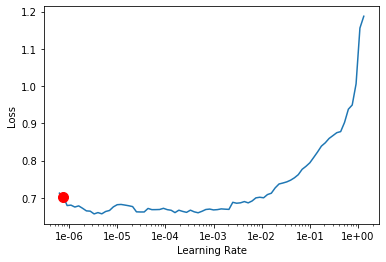

In [39]:
learn.freeze_to(-3)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [40]:
learn.fit_one_cycle(10,7.5e-07,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.699215,0.715741,0.688484,0.688484,00:07
1,0.677088,0.718185,0.681027,0.681027,00:07
2,0.698356,0.716914,0.681856,0.681856,00:07
3,0.661410,0.714750,0.689312,0.689312,00:07
4,0.672484,0.713412,0.690969,0.690969,00:07
5,0.685465,0.714013,0.686827,0.686827,00:07
6,0.699085,0.715282,0.685170,0.685170,00:07
7,0.693006,0.713369,0.690969,0.690969,00:07
8,0.695848,0.713826,0.685170,0.685170,00:07
9,0.687596,0.720036,0.682684,0.682684,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 1.00E-06


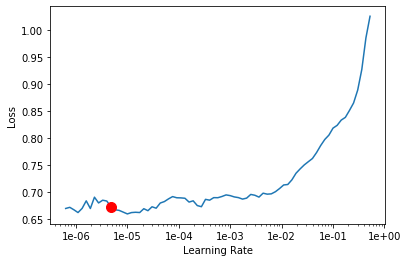

In [41]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [42]:
learn.fit_one_cycle(6, 4.8e-06,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.669991,0.714591,0.686827,0.686827,00:07
1,0.685279,0.710921,0.692626,0.692626,00:07
2,0.656413,0.710247,0.691798,0.691798,00:07
3,0.665540,0.711058,0.692626,0.692626,00:07
4,0.679016,0.712320,0.688484,0.688484,00:07
5,0.666494,0.711104,0.688484,0.688484,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


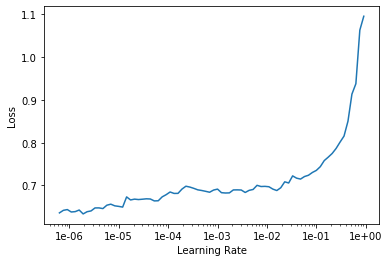

In [43]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [44]:
learn.fit_one_cycle(5, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.687753,0.684429,0.699254,0.699254,00:09
1,0.635761,0.542583,0.766363,0.766363,00:09
2,0.529599,0.526789,0.784590,0.784590,00:09
3,0.422027,0.533717,0.785418,0.785418,00:09
4,0.354679,0.525092,0.790389,0.790389,00:09


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


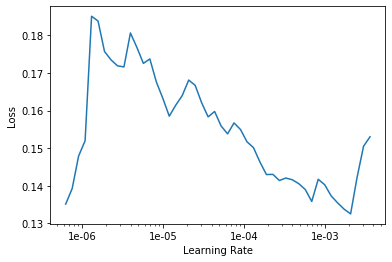

In [59]:
learn.lr_find(); learn.recorder.plot()

In [60]:
learn.fit_one_cycle(10,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.097787,1.292961,0.626667,0.626667,00:03
1,0.109399,1.223577,0.606667,0.606667,00:04
2,0.131562,1.267795,0.593333,0.593333,00:04
3,0.152960,1.417592,0.593333,0.593333,00:04
4,0.147234,1.346362,0.606667,0.606667,00:04
5,0.137955,1.240260,0.626667,0.626667,00:04
6,0.137904,1.188245,0.613333,0.613333,00:04
7,0.119651,1.161442,0.633333,0.633333,00:04
8,0.109235,1.169117,0.620000,0.620000,00:04
9,0.097784,1.180319,0.620000,0.620000,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


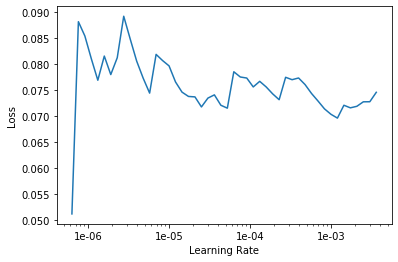

In [61]:
learn.lr_find(); learn.recorder.plot()

In [62]:
learn.fit_one_cycle(15,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.073561,1.181819,0.626667,0.626667,00:04
1,0.086489,1.208847,0.640000,0.640000,00:04
2,0.076092,1.212426,0.620000,0.620000,00:01
3,0.076359,1.267633,0.613333,0.613333,00:01
4,0.077932,1.316755,0.593333,0.593333,00:01
5,0.074365,1.414496,0.600000,0.600000,00:01
6,0.072296,1.534045,0.593333,0.593333,00:01
7,0.069676,1.517587,0.573333,0.573333,00:01
8,0.070126,1.531858,0.586667,0.586667,00:01
9,0.069747,1.518744,0.586667,0.586667,00:01


In [47]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ftxt.TextClassificationInterpretation(learn, preds, y, losses)

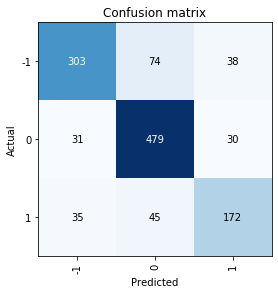

In [48]:
interp.plot_confusion_matrix()